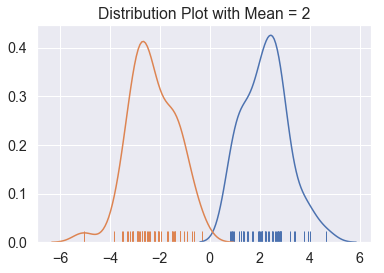

In [6]:
import numpy as np
%matplotlib inline

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.figure()
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = 2")
plt.show()

In [45]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(5000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            print(X[prob_index])
            posterior_class_counts[tree.apply(X[prob_index]).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

#rf_entropy_estimate_bagging(X, y, 500, .32)


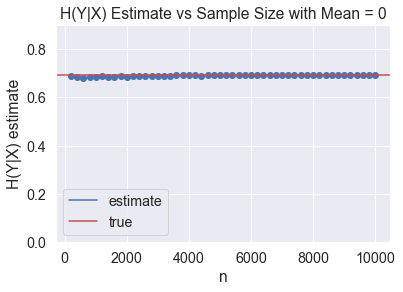

In [3]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 51)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .9)
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

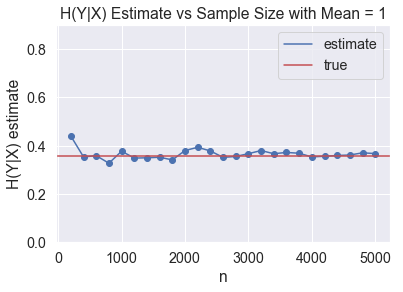

In [41]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 26)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(1)
plt.scatter(sample_sizes[: 25], cond_entropy[:25])
line_est, = plt.plot(sample_sizes[:25], cond_entropy[:25], label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .9)
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

# High dimension

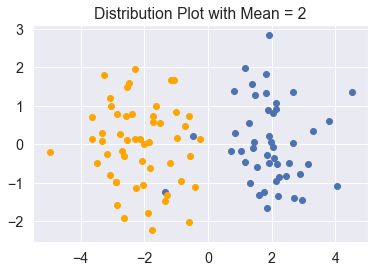

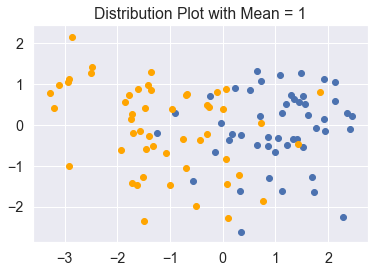

In [4]:
import numpy as np

def get_multivariate_sample(n, d, mean):
    x_sample = []
    y_sample = []
    means = np.zeros(d)
    means[0] = mean
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.multivariate_normal(-means, np.identity(d))
        else:
            x = np.random.multivariate_normal(means, np.identity(d))
        x_sample.append(x.tolist())
        y_sample.append(y)
    return x_sample, y_sample

import matplotlib.pyplot as plt

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_multivariate_sample(100, 2, 2)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 2")
plt.show()

X, y = get_multivariate_sample(100, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 1")
plt.show()


In [9]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(5000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

#rf_entropy_estimate_bagging(X, y, 500, .32)


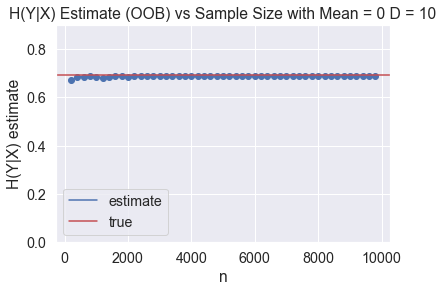

In [25]:
def get_cond_entropy_vs_n_oob(mean, d):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 50)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 300, .32, depth = 30))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(0, 10)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .9)
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 0 D = 10")
plt.show()

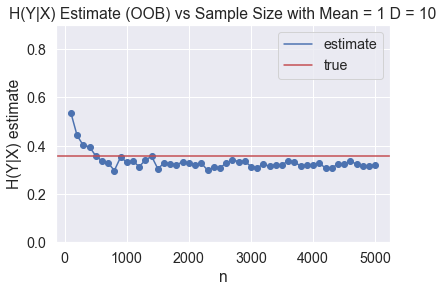

In [14]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n_oob(mean, d):
    conditional_entropy = []
    sample_sizes = [i*100 for i in range(1, 51)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 1000, .32, depth = 30))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 10)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .9)
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 10")
plt.show()

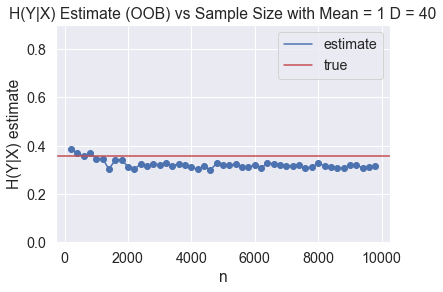

In [28]:
def get_cond_entropy_vs_n_oob(mean, d):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 50)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 300, .32, depth = 30))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 40)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .9)
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 40")
plt.show()

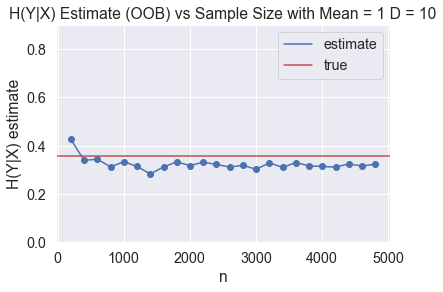

In [53]:
def get_cond_entropy_vs_n_oob(mean, d):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 25)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 300, .32, depth = 30))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 10)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .9)
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 10")
plt.show()

In [8]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .5, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = [i for i in range(len(X)) if i not in unsampled_indices]
        prob_indices = unsampled_indices
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        eval_class_probs = np.asarray([node_counts[x] for x in tree.apply(X[sampled_indices])])
        # get probability for out of bag samples
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[sampled_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[sampled_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .5, depth = None)


0.6717685478186909

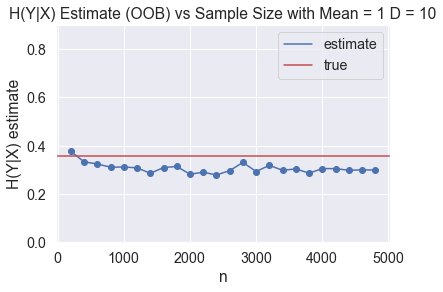

In [60]:
def get_cond_entropy_vs_n_oob(mean, d):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 25)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 300, .5, depth = 30))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 10)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .9)
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 10")
plt.show()

In [4]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .5, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = [i for i in range(len(X)) if i not in unsampled_indices]
        prob_indices = unsampled_indices
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        """
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        """
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[sampled_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[sampled_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[sampled_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .5, depth =None)


0.6369491057297958

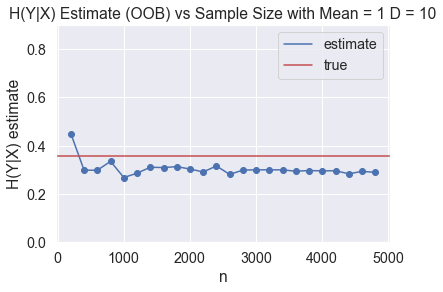

In [63]:
def get_cond_entropy_vs_n_oob(mean, d):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 25)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 300, .5, depth = 30))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 10)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .9)
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 10")
plt.show()

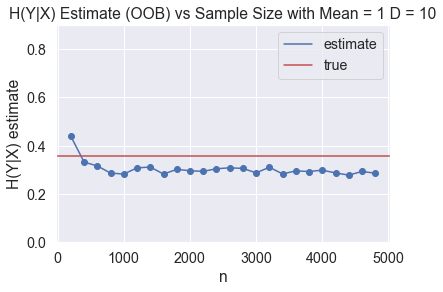

In [64]:
def get_cond_entropy_vs_n_oob(mean, d):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 25)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 300, .5, depth = None))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 10)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .9)
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 10")
plt.show()

# Y is continuous

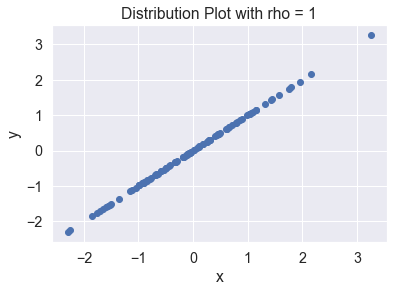

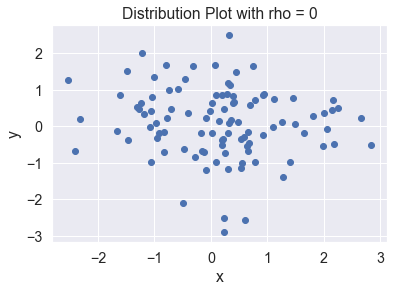

In [7]:
import numpy as np

def get_cont_sample(n,  rho):
    x_sample = []
    y_sample = []
    means = np.zeros(2)
    cov = np.array(((1, rho), (rho, 1)))
    for i in range(n):
        x = np.random.multivariate_normal(means, cov)
        x_sample.append(x[0])
        y_sample.append(x[1])
    return x_sample, y_sample

import matplotlib.pyplot as plt



X, y = get_cont_sample(100, 1)
plt.scatter(X, y, c = 'b')
plt.title("Distribution Plot with rho = 1")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

X, y = get_cont_sample(100, 0)
plt.scatter(X, y, c = 'b')
plt.title("Distribution Plot with rho = 0")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [14]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

X, y = get_cont_sample(1000, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    for tree in model:
        # get out of bag indicies
        
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        print(tree.tree_.n_node_samples)
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        for sample in unsampled_indices:
            print(node_counts(tree.apply(X[sample])))
        # get probs for eval samples
        """
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            print(X[prob_index])
            posterior_class_counts[tree.apply(X[prob_index]).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
        """
        break
    # calculate p(y|X = x) for all x's
    #probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    #entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    #entropies = np.nan_to_num(entropies)
    return np.mean(0)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .32)


[278 129  37  15   5   1   4   2   1   1   2   1   1  10   7   4   1   3
   2   1   1   1   3   1   2   1   1   3   1   2   1   1  22  10   2   1
   1   8   3   2   1   1   1   5   3   2   1   1   1   2   1   1  12   8
   4   1   3   1   2   4   3   2   1   1   1   1   4   1   3   1   2   1
   1  92  40  21  11   5   4   2   1   1   2   1   1   1   6   2   1   1
   4   3   1   2   1   1   1  10   4   3   1   2   1   6   3   1   2   1
   1   3   1   2   1   1  19   9   5   1   4   3   1   2   1   1   1   4
   3   1   2   1   1   1  10   4   3   2   1   1   1   1   6   4   1   3
   2   1   1   1   2   1   1  52  27  15   9   2   1   1   7   2   1   1
   5   3   2   1   1   1   2   1   1   6   3   2   1   1   1   3   1   2
   1   1  12   4   2   1   1   2   1   1   8   6   3   2   1   3   1   2
   2   1   1  25  12   5   3   1   2   1   1   2   1   1   7   3   1   2
   1   1   4   2   1   1   2   1   1  13   5   2   3   2   1   1   1   8
   6   2   1   1   4   2   1   1   2   1   1   2   

ValueError: Expected 2D array, got 1D array instead:
array=[-0.920681].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.